# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.
    

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [2]:
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle
import mpmath

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: ***@Juninho_Gari***


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [3]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [4]:
#Produto escolhido:
produto = 'Uber'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [5]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [6]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



In [7]:
%matplotlib inline
import pandas as pd
from mpmath import mpf
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
# Lendo o Excel
d_treino = pd.read_excel("Uber.xlsx", "Treinamento", sep=",")
d_treino = pd.read_excel("Uber.xlsx", sheetname = "Treinamento")
d_treino = d_treino.loc[:,["Treinamento", "CLASS"]]


In [9]:
# Value Counts
value_treino = d_treino.CLASS.value_counts(True)

In [10]:
# Probabilidade Relevante
prob_rel = value_treino.loc["R"]


In [11]:
# Probabilidade Irrelevante
prob_irrel = value_treino.loc["I"]


In [12]:
# String Completa
tweet_completo = np.sum(d_treino.Treinamento + " ")
tweet_completo_rel = np.sum(d_treino[d_treino.CLASS =="R"].Treinamento + " ")
tweet_completo_irrel = np.sum(d_treino[d_treino.CLASS =="I"].Treinamento + " ")

# Quantidade de Strings
nt_rel = len(d_treino[d_treino.CLASS == "R"])
nt_irrel = len(d_treino[d_treino.CLASS == "I"])
nt_tot = nt_rel + nt_irrel

In [13]:
# Limpeza de Strings
import string

remover = set(string.punctuation)

def Limpeza(tweet_completo):
    tweet_completo = tweet_completo.split()
    lista = []
    for i in tweet_completo:
        for x in i:
            if x in remover:
                i = i.replace(x, "")
        lista.append(i)
    return lista

rel_limpo = Limpeza(tweet_completo_rel)
irrel_limpo = Limpeza(tweet_completo_irrel)

In [14]:
p_rel = pd.Series(rel_limpo)
p_irrel = pd.Series(irrel_limpo)
p_tot = pd.Series(rel_limpo + irrel_limpo)

In [15]:
p_dif = len(p_tot.value_counts())

p_dif_rel = len(p_rel.value_counts())
p_dif_irrel = len(p_irrel.value_counts())


In [16]:
n_p_dif_rel = (p_rel.value_counts())
n_p_dif_irrel = (p_irrel.value_counts())
n_p_dif_tot = (p_tot.value_counts())

# Classificador

## Irrelevante

In [17]:
lista_p_irrel = []
lista_pb_irrel = []

# Bayes (Irrelevante)

for palavra in n_p_dif_irrel.index:
    
    pb_irrel = ( n_p_dif_irrel[palavra] + 1) / ( len(p_irrel) + p_dif)
    lista_p_irrel.append(palavra)
    lista_pb_irrel.append(pb_irrel)
    
dic_irrel = dict()

# Colocando as palavras em um dicionario com suas probabilidades

def Dic(lista_p, lista_pb, dic):
    for i in range(len(lista_p)):
        dic[lista_p[i]] = lista_pb[i]
    return(dic)

pb_p_irrel = Dic(lista_p_irrel, lista_pb_irrel, dic_irrel)



## Relevante

In [18]:
lista_p_rel = []
lista_pb_rel = []

# Bayes (Relevante)

for palavra in n_p_dif_rel.index: 
    pb_rel = ( n_p_dif_rel[palavra] + 1) / ( len(p_rel) + p_dif)
    lista_p_rel.append(palavra)
    lista_pb_rel.append(pb_rel)
    
dic_rel = dict()

pb_p_rel = Dic(lista_p_rel, lista_pb_rel, dic_rel)


## Total (Funções)

In [19]:

def Prob_Tot(Tweet, dic, p_irrel, p_rel, p_dif):
    Tweet=Tweet.split()
    lista=[]
    ProbF = mpmath.mpf(1.000)
    if dic == pb_p_rel:
        for p in Tweet:  
            if p in dic:
                ProbF = ProbF * dic[p]
            else:
                ProbF = ProbF * ((1) / ( len(p_irrel) + p_dif))               
    else:
        for p in Tweet:  
            if p in dic:
                ProbF = ProbF * dic[p]
            else:
                ProbF = ProbF * ((1) / ( len(p_rel) + p_dif))
    return ProbF

                          
def Comparacao(Prob_Tot, Tweet, dic_rev, dic_irrev, p_irrel, p_rel, p_dif):
    Relev = Prob_Tot(Tweet, dic_rev, p_irrel, p_rel, p_dif)
    Irrelev = Prob_Tot(Tweet, dic_irrev, p_irrel, p_rel, p_dif)
    if Relev>Irrelev:
        d_teste.loc[(d_teste.Teste == Tweet), 'Classificador'] = 'R'
    elif Relev == Irrelev:
        d_teste.loc[(d_teste.Teste == Tweet), 'Classificador'] = 'Indefinido'
    else:
        d_teste.loc[(d_teste.Teste == Tweet), 'Classificador'] = 'I'
        


___
## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante.

In [20]:
# Lendo o Excel
d_teste = pd.read_excel("Uber.xlsx", "Teste", sep=",")
d_teste = pd.read_excel("Uber.xlsx", sheetname = "Teste")
d_teste = d_teste.loc[:,["Teste", "CLASS", "Classificador", "Verificacao"]]


In [21]:
# Value Counts
value_teste = d_teste.CLASS.value_counts(True)

In [22]:
# Probabilidade Relevante
prob_rel = value_teste.loc["R"]
prob_rel

0.28999999999999998

In [23]:
# Probabilidade Irrelevante
prob_irrel = value_teste.loc["I"]
prob_irrel

0.70999999999999996

In [24]:
# String Completa
tweet_completo = np.sum(d_teste.Teste + " ")
tweet_completo_rel = np.sum(d_teste[d_treino.CLASS =="R"].Teste + " ")
tweet_completo_irrel = np.sum(d_teste[d_teste.CLASS =="I"].Teste + " ")

# Quantidade de Strings
nt_rel = len(d_teste[d_teste.CLASS == "R"])
nt_irrel = len(d_teste[d_teste.CLASS == "I"])
nt_tot = nt_rel + nt_irrel


/Users/adesktop/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# Limpeza de Strings

rel_limpo = Limpeza(tweet_completo_rel)
irrel_limpo = Limpeza(tweet_completo_irrel)


In [26]:
p_rel = pd.Series(rel_limpo)
p_irrel = pd.Series(irrel_limpo)
p_tot = pd.Series(rel_limpo + irrel_limpo)

In [27]:
p_dif = len(p_tot.value_counts())

p_dif_rel = len(p_rel.value_counts())
p_dif_irrel = len(p_irrel.value_counts())

In [28]:
n_p_dif_rel = (p_rel.value_counts())
n_p_dif_irrel = (p_irrel.value_counts())
n_p_dif_tot = (p_tot.value_counts())

In [29]:
lista_p_irrel = []
lista_pb_irrel = []

# Bayes (Irrelevante)

for palavra in n_p_dif_irrel.index:
    
    pb_irrel = ( n_p_dif_irrel[palavra] + 1) / ( len(p_irrel) + p_dif)
    lista_p_irrel.append(palavra)
    lista_pb_irrel.append(pb_irrel)
    
dic_irrel = dict()

# Colocando as palavras em um dicionario com suas probabilidades

pb_p_irrel = Dic(lista_p_irrel, lista_pb_irrel, dic_irrel)

In [30]:
lista_p_rel = []
lista_pb_rel = []

# Bayes (Relevante)

for palavra in n_p_dif_rel.index: 
    pb_rel = ( n_p_dif_rel[palavra] + 1) / ( len(p_rel) + p_dif)
    lista_p_rel.append(palavra)
    lista_pb_rel.append(pb_rel)
    
dic_rel = dict()

pb_p_rel = Dic(lista_p_rel, lista_pb_rel, dic_rel)


In [31]:
for x in d_teste.Teste:
    Comp = Comparacao(Prob_Tot, x, dic_rel, dic_irrel, p_irrel, p_rel, p_dif)
    #print(Comp)


In [32]:
d_teste.loc[(d_teste.CLASS == 'R') & (d_teste.Classificador == 'R' ), 'Verificacao'] = 'Positivo Verdadeiro'
d_teste.loc[(d_teste.CLASS == 'R') & (d_teste.Classificador == 'I' ), 'Verificacao'] = 'Negativo Falso'
d_teste.loc[(d_teste.CLASS == 'I') & (d_teste.Classificador == 'R' ), 'Verificacao'] = 'Positivo Falso'
d_teste.loc[(d_teste.CLASS == 'I') & (d_teste.Classificador == 'I' ), 'Verificacao'] = 'Negativo Verdadeiro'

In [33]:
d_teste.Verificacao.value_counts(True)*100

Negativo Verdadeiro    64.0
Negativo Falso         24.0
Positivo Falso          7.0
Positivo Verdadeiro     5.0
Name: Verificacao, dtype: float64

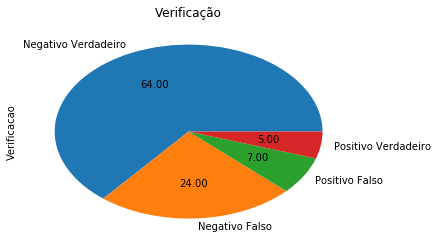

In [34]:
adim = d_teste.Verificacao.value_counts()
adim.plot(kind='pie', autopct="%.2f",legend=False)
plt.title('Verificação')

___
## Concluindo


   A partir dos resultados, podemos inferir que o Classificador não é totalmente eficiente, porém tem uma grande porcetagem de acerto e consegue refletir com precisão satisfatória se um tweet é relevante ou não, como no caso do teste, em que o Classificador teve uma taxa de sucesso de 69%.
   
   Analisando as porcentagens obtidas, foi possível perceber que o Classificador tem mais facilidade em dizer se um tweet é irrelevante, visto que acertou 87,7% deste tipo de tweet, enquato acertou apenas 17,2% dos tweets relevantes.
   
   Mensagens com tom figurativo, sendo sarcasmo e dupla negação exemplos, são tratadas da mesma forma que todas as outras, o que interfere no resultado, porém com o código atual não foi possível discerní-las.
   
   Para uma próxima versão do classificador, a fim de deixá-lo mais eficiente, o programa seria capaz de diferenciar mensagens sarcásticas ou com dupla negação, e seriam removidas palvras de pouca importância, como "a", "e", "ou", etc. Além disso, haveria um agrupamento de palavras de significado semelhante, como "Uber", "UberBrasil", "UberEats", etc.
   